<a href="https://colab.research.google.com/github/Purvav0511/Waveform-based-Audio-Classification-of-Environmental-Sounds-Using-Deep-Learning/blob/main/Copy_of_DL_Project_RAW_p1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Install Required Package:** 

The script starts by installing the necessary package torchaudio using pip. torchaudio is a library that is part of the PyTorch ecosystem. It's specifically designed to handle tasks related to audio and provides a wide array of functionalities for audio data preprocessing and augmentations.

In [ ]:
# Install required package
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **2. Import Libraries:**
The script then imports a variety of libraries that are needed to perform the upcoming tasks.

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torchaudio.transforms as T


In [ ]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and extract dataset
!wget -P 'drive/My Drive' https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

--2023-05-16 20:25:10--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘drive/My Drive/UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  6.83MB/s    in 21m 19s 

2023-05-16 20:46:31 (4.49 MB/s) - ‘drive/My Drive/UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



In [ ]:
!tar -xzf 'drive/My Drive/UrbanSound8K.tar.gz'

# **3. Define Target Sample Rate and Duration:** 
The target sample rate is set to 16,000 Hz, and the target duration is set to 4 seconds. This means we're aiming to process audio such that it has a sample rate of 16,000 Hz and a total duration of 4 seconds. These values may have been chosen based on the specific requirements of the task at hand or to standardize the audio input for a machine learning model.

In [ ]:
# Define target sample rate and duration for audio preprocessing
target_sample_rate = 16000
target_duration = 4  # in seconds

## **4. Function to Preprocess Audio Waveform:** 
The preprocess_audio_waveform function is defined to load an audio file from a given path, downmix it to mono, resample it to the target sample rate, and truncate or pad it to the target duration

In [ ]:
# Function to preprocess audio waveform
def preprocess_audio_waveform(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    waveform = waveform.mean(dim=0, keepdim=True)  # Downmix to mono by averaging channels
    waveform = torchaudio.transforms.Resample(sample_rate, target_sample_rate)(waveform)
    num_samples = target_sample_rate * target_duration
    if waveform.shape[1] < num_samples:
        padding = torch.zeros(1, num_samples - waveform.shape[1])
        waveform = torch.cat([waveform, padding], axis=-1)
    elif waveform.shape[1] > num_samples:
        waveform = waveform[:, :num_samples]
    return waveform


In [ ]:
target_sample_rate = 16000
target_duration = 4  # in seconds

# **5. Function to Preprocess Audio Spectrogram:** 
 The preprocess_audio_spectogram function is defined to load an audio file from a given path, downmix it to mono, resample it to the target sample rate, convert it to a Mel spectrogram, and then truncate or pad the spectrogram to a fixed length.

In [ ]:
# Function to preprocess audio spectrogram
def preprocess_audio_spectogram(file_path, num_mels=128, fixed_length=400):
    waveform, sample_rate = torchaudio.load(file_path)
    waveform = waveform.mean(dim=0, keepdim=True)  # Downmix to mono by averaging channels
    waveform = T.Resample(sample_rate, target_sample_rate)(waveform)
    spectrogram = T.MelSpectrogram(sample_rate, n_mels=num_mels)(waveform)

    # Zero pad / trim spectrogram
    if spectrogram.shape[2] < fixed_length:
        padding = torch.zeros((1, num_mels, fixed_length - spectrogram.shape[2]))
        spectrogram = torch.cat([spectrogram, padding], axis=-1)
    elif spectrogram.shape[2] > fixed_length:
        spectrogram = spectrogram[:, :, :fixed_length]

    return spectrogram


# **6. Custom Dataset Class for Spectrogram Data:** 
The AudioDatasetSpec class extends the Dataset class provided by PyTorch. The purpose of this class is to provide a convenient way to load and preprocess audio files from a directory, convert them to Mel spectrograms, and provide them as input data for a machine learning model.

In [ ]:
# Create a custom Dataset for spectrogram data
class AudioDatasetSpec(Dataset):
    def __init__(self, metadata, base_dir, transform=None):
        self.metadata = metadata
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        row = self.metadata.iloc[index]
        file_path = os.path.join(self.base_dir, f"fold{row['fold']}", row['slice_file_name'])
        spectrogram = preprocess_audio_spectogram(file_path)
        label = row['classID']
        return spectrogram, label

    def visualize_spectrogram(self, num_samples=10):
        random_indices = np.random.choice(len(self.metadata), size=num_samples, replace=False)
        plt.figure(figsize=(15, 10))

        for i, index in enumerate(random_indices):
            spectrogram, label = self.__getitem__(index)
            spectrogram = spectrogram.squeeze().numpy()

            plt.subplot(2, 5, i + 1)
            plt.imshow(spectrogram, aspect='auto', origin='lower')
            plt.title(f"Sample {i + 1}, Label: {label}")
            plt.xlabel("Time")
            plt.ylabel("Frequency")

        plt.tight_layout()
        plt.show()


# **7. Load Metadata and Create Train, Validation, and Test Sets:** 

The metadata for the audio files is loaded from a CSV file into a pandas DataFrame. This metadata is then split into train, validation, and test sets using the train_test_split function from the sklearn.model_selection module. The split is stratified based on the classID column of the metadata, ensuring that the distribution of classes is the same in all three sets.

In [ ]:
# Load metadata and create train, validation, and test sets
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
train_metadata, test_metadata = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata['classID'])
train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.25, random_state=42, stratify=train_metadata['classID'])

# **8. Create Train, Validation, and Test Datasets:** 
Instances of the AudioDatasetSpec class are created for the train, validation, and test sets. The spectrograms in the training dataset are visualized using the visualize_spectrogram method.

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


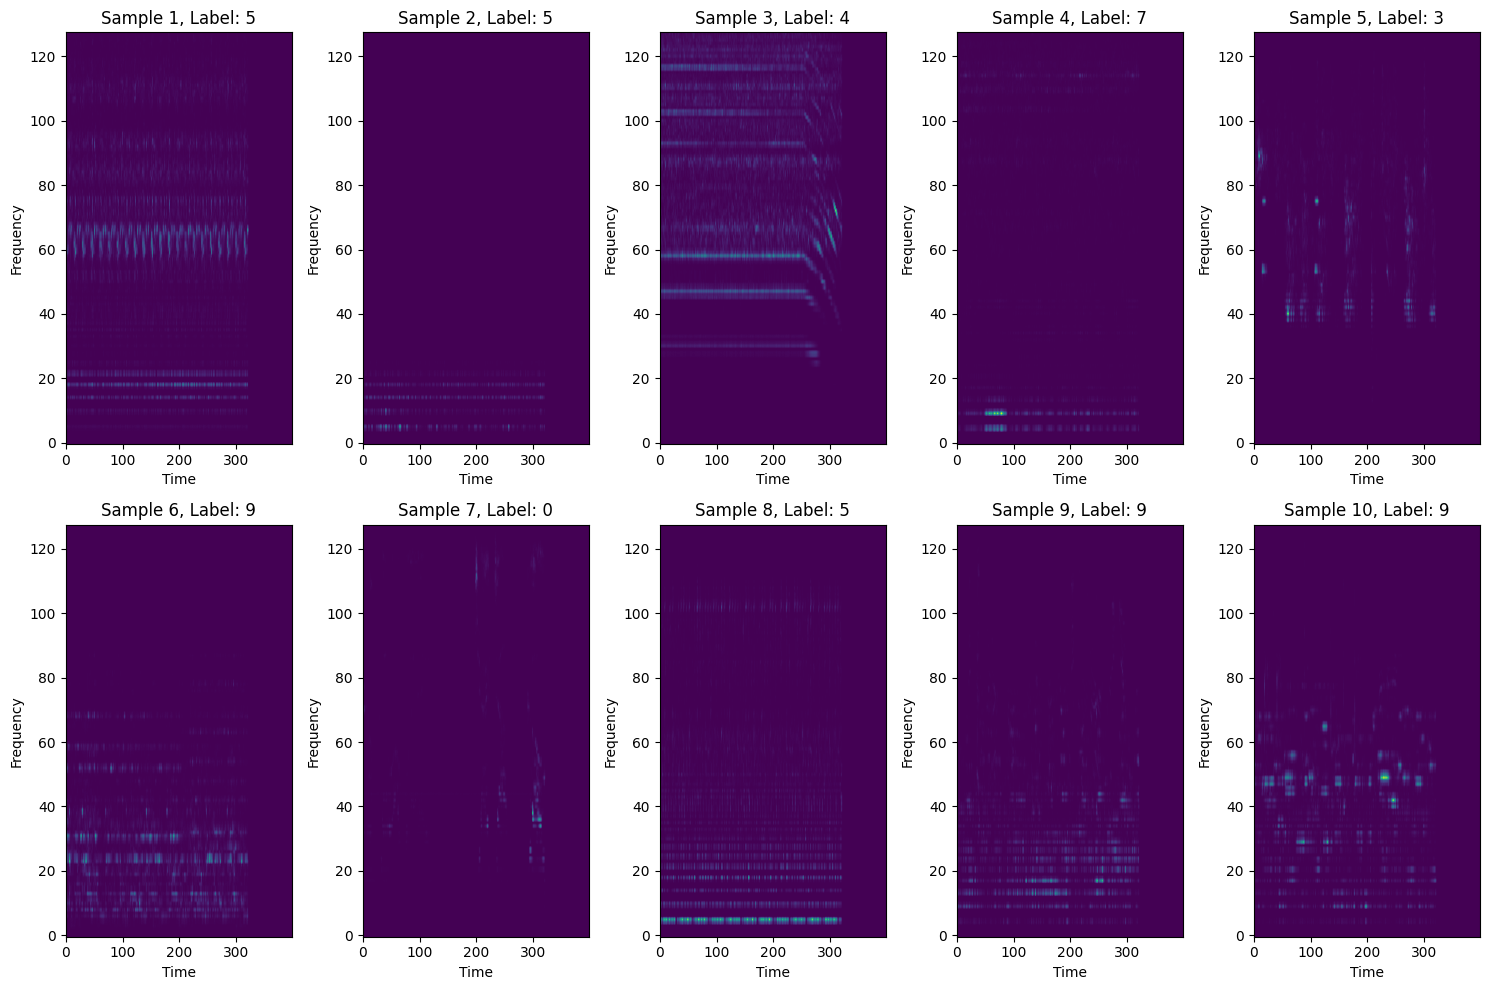

In [ ]:
#Create train, validation, and test datasets
train_dataset = AudioDatasetSpec(train_metadata, 'UrbanSound8K/audio')
train_dataset.visualize_spectrogram()
val_dataset = AudioDatasetSpec(val_metadata, 'UrbanSound8K/audio')
test_dataset = AudioDatasetSpec(test_metadata, 'UrbanSound8K/audio')

# **9. Custom Dataset Class for Waveform Data:** 
The AudioDataset class extends the Dataset class provided by PyTorch. This class is designed to load and preprocess audio files from a directory, convert them into waveforms, and provide them as input data for a machine learning model.

In [ ]:
#Create a custom Dataset for waveform data
class AudioDataset(Dataset):
    def __init__(self, metadata, base_dir, transform=None):
        self.metadata = metadata
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
      row = self.metadata.iloc[index]
      #file_path = os.path.join(self.base_dir, row['fold'], row['slice_file_name'])
      file_path = os.path.join(self.base_dir, f"fold{row['fold']}", row['slice_file_name'])
      #print(f"Loading file: {file_path}")
      waveform = preprocess_audio_waveform(file_path)
      label = row['classID']
      return waveform, label

    def visualize_waveform(self, num_samples=10):
        random_indices = np.random.choice(len(self.metadata), size=num_samples, replace=False)
        plt.figure(figsize=(15, 10))

        for i, index in enumerate(random_indices):
            waveform, label = self.__getitem__(index)
            waveform = waveform.squeeze().numpy()

            plt.subplot(2, 5, i + 1)
            plt.plot(waveform)
            plt.title(f"Sample {i + 1}, Label: {label}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")

        plt.tight_layout()
        plt.show()

# **10. Load Metadata and Create Train, Validation, and Test Sets:** 
The metadata for the audio files is loaded from a CSV file into a pandas DataFrame. This metadata is then split into train, validation, and test sets using the train_test_split function from the sklearn.model_selection module. The split is stratified based on the classID column of the metadata, ensuring that the distribution of classes is the same in all three sets.

In [ ]:
# Load metadata and create train, validation, and test sets
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
train_metadata, test_metadata = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata['classID'])
train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.25, random_state=42, stratify=train_metadata['classID'])



# **11. Create Train, Validation, and Test Datasets for Waveform Data:** 
Instances of the AudioDataset class are created for the train, validation, and test sets. The waveforms in the training dataset are visualized using the visualize_waveform method.

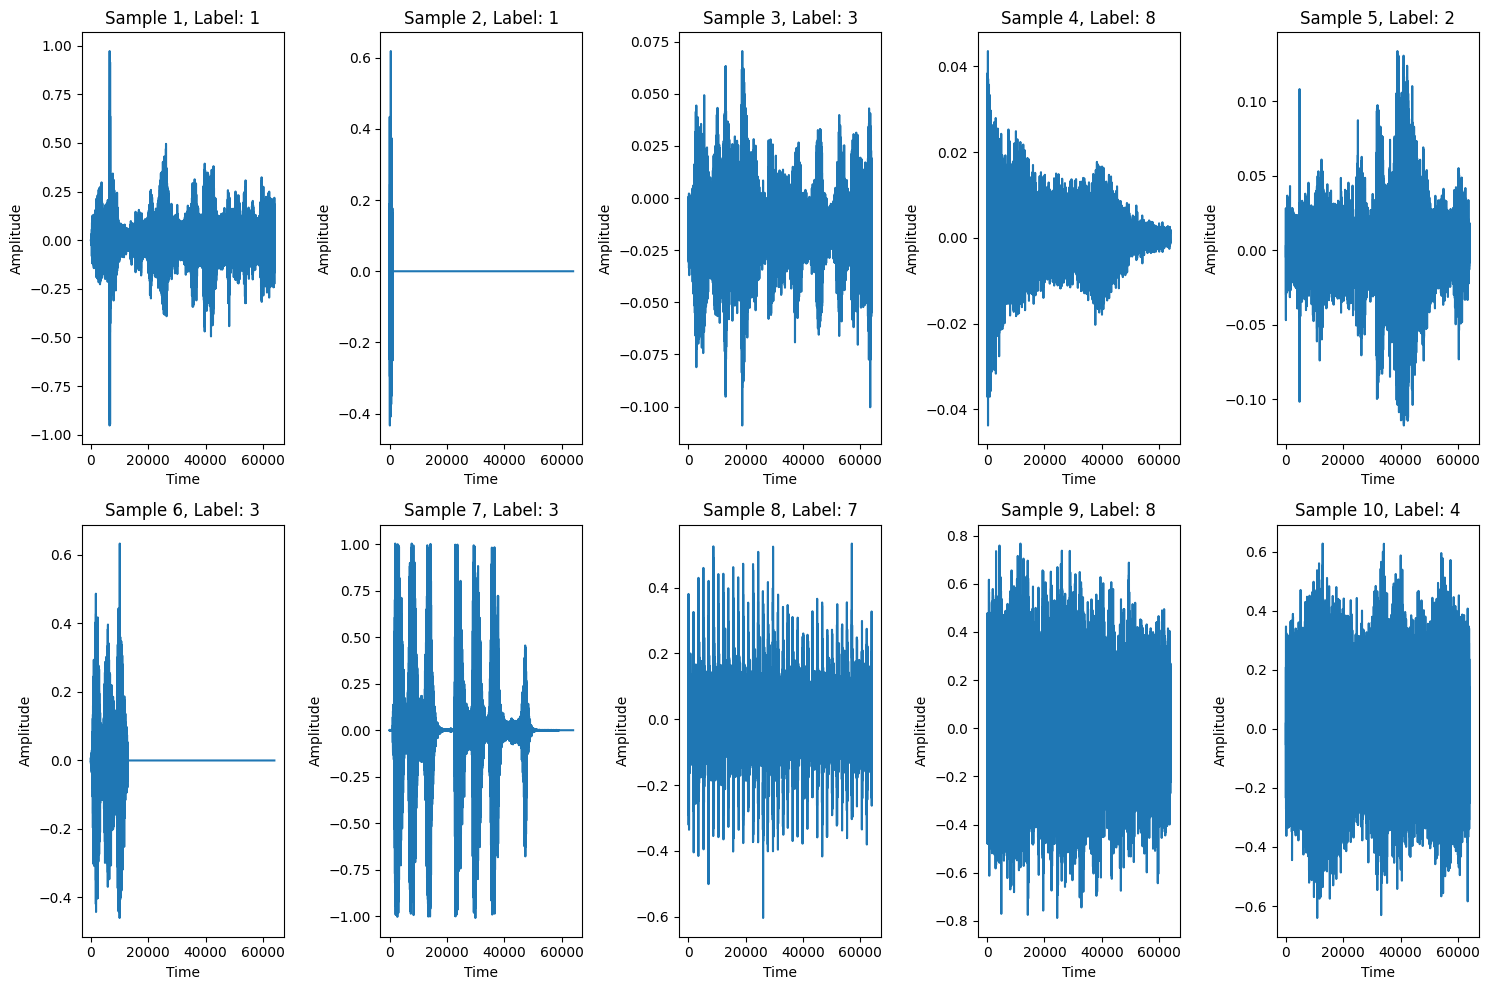

In [ ]:
#Create train, validation, and test datasets for waveform data
train_dataset = AudioDataset(train_metadata, 'UrbanSound8K/audio')
train_dataset.visualize_waveform()
val_dataset = AudioDataset(val_metadata, 'UrbanSound8K/audio')
test_dataset = AudioDataset(test_metadata, 'UrbanSound8K/audio')

# **12. Creating Data Loaders:** 
PyTorch's DataLoader class is used to create data loaders for the train, validation, and test datasets. A data loader combines a dataset and a sampler, and provides an iterable over the given dataset. It's used to feed data into a PyTorch model in batches, which is more memory-efficient than loading the entire dataset into memory at once.

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# **13. Defining the AudioToVisualModel Class:** 
The AudioToVisualModel class extends PyTorch's nn.Module class. It represents a model that uses a combination of convolutional layers (CNN) and recurrent layers (RNN - either GRU or LSTM), followed by a linear layer for classification.

In [ ]:
#Define the AudioToVisualModel class for the audio-to-visual model
class AudioToVisualModel(nn.Module):
    def __init__(self, input_shape, num_classes, rnn_type="gru", rnn_hidden_size=512, rnn_num_layers=2):
        super(AudioToVisualModel, self).__init__()

        # CNN Layers
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_shape[0], 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size = 3, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size = 3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # RNN Layers
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        self.rnn_type = rnn_type.lower()

        if self.rnn_type == "gru":
            self.rnn = nn.GRU(512, rnn_hidden_size, rnn_num_layers, batch_first=True)
        elif self.rnn_type == "lstm":
            self.rnn = nn.LSTM(512, rnn_hidden_size, rnn_num_layers, batch_first=True)
        else:
            raise ValueError("Invalid RNN type. Choose 'gru' or 'lstm'.")

        # Output Layers
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.transpose(1, 2)
        
        if self.rnn_type == "lstm":
            h0 = torch.zeros(self.rnn_num_layers, x.size(0), self.rnn_hidden_size).to(x.device)
            c0 = torch.zeros(self.rnn_num_layers, x.size(0), self.rnn_hidden_size).to(x.device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            h0 = torch.zeros(self.rnn_num_layers, x.size(0), self.rnn_hidden_size).to(x.device)
            out, _ = self.rnn(x, h0)

        out = out[:, -1, :]
        out = self.fc1(out)

        return out


# **14. Setting Up the Model:**

In [ ]:
# For the UrbanSound8k model
from torchsummary import summary

input_shape = (1, 4 * 22050)  # 1 channel, 4 seconds, 22050 sample rate
num_classes = 10  # Number of classes in the UrbanSound8K dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioToVisualModel(input_shape, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size = input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 64, 44100]             384
       BatchNorm1d-2            [-1, 64, 44100]             128
              ReLU-3            [-1, 64, 44100]               0
         MaxPool1d-4            [-1, 64, 22050]               0
            Conv1d-5           [-1, 128, 11025]          24,704
       BatchNorm1d-6           [-1, 128, 11025]             256
              ReLU-7           [-1, 128, 11025]               0
         MaxPool1d-8            [-1, 128, 5512]               0
            Conv1d-9            [-1, 256, 2757]          98,560
      BatchNorm1d-10            [-1, 256, 2757]             512
             ReLU-11            [-1, 256, 2757]               0
        MaxPool1d-12            [-1, 256, 1378]               0
           Conv1d-13             [-1, 512, 689]         393,728
      BatchNorm1d-14             [-1, 5

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=0ec415de4d392fbe7ba319fa42e95f517efe9d85e19924d32565956f68d39db1
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


# **15. Training Function:**

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    return running_loss / len(dataloader.dataset)

# **16. Validation Function:**

In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            correct_predictions += (predicted == labels).sum().item()

    return running_loss / len(dataloader.dataset), correct_predictions / len(dataloader.dataset)

In [ ]:
num_epochs = 50
best_val_loss = float('inf')

In [ ]:
train_metadata['fold'] = train_metadata['fold'].astype(str)
val_metadata['fold'] = val_metadata['fold'].astype(str)
test_metadata['fold'] = test_metadata['fold'].astype(str)


In [ ]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/50 - Train Loss: 1.8460, Val Loss: 1.7418, Val Acc: 0.3663
Epoch 2/50 - Train Loss: 1.4600, Val Loss: 1.3351, Val Acc: 0.5575
Epoch 3/50 - Train Loss: 1.1646, Val Loss: 1.1162, Val Acc: 0.6176
Epoch 4/50 - Train Loss: 0.9798, Val Loss: 1.0360, Val Acc: 0.6468
Epoch 5/50 - Train Loss: 0.8355, Val Loss: 0.8879, Val Acc: 0.6995
Epoch 6/50 - Train Loss: 0.6979, Val Loss: 0.8956, Val Acc: 0.6898
Epoch 7/50 - Train Loss: 0.6509, Val Loss: 0.9036, Val Acc: 0.7029
Epoch 8/50 - Train Loss: 0.5293, Val Loss: 1.2647, Val Acc: 0.6297
Epoch 9/50 - Train Loss: 0.4380, Val Loss: 0.6646, Val Acc: 0.7911
Epoch 10/50 - Train Loss: 0.4084, Val Loss: 0.6958, Val Acc: 0.7756
Epoch 11/50 - Train Loss: 0.3086, Val Loss: 0.7668, Val Acc: 0.7527
Epoch 12/50 - Train Loss: 0.2610, Val Loss: 0.6893, Val Acc: 0.7848
Epoch 13/50 - Train Loss: 0.2068, Val Loss: 0.8323, Val Acc: 0.7590
Epoch 14/50 - Train Loss: 0.2156, Val Loss: 0.9252, Val Acc: 0.7287
Epoch 15/50 - Train Loss: 0.1904, Val Loss: 0.6834, Val A

# **Test Accuracy:**

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Test Loss: 0.6208, Test Acc: 0.7962


In [ ]:
# Compute predictions
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


# **Confusion Matrix:**

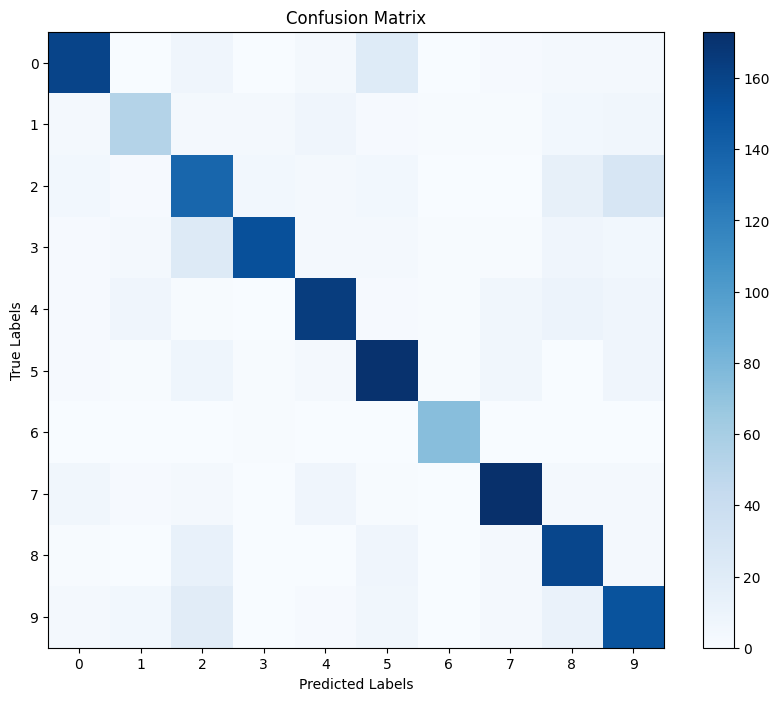

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(num_classes), range(num_classes))
plt.yticks(np.arange(num_classes), range(num_classes))
plt.show()


# **Train and Validation Curve:**

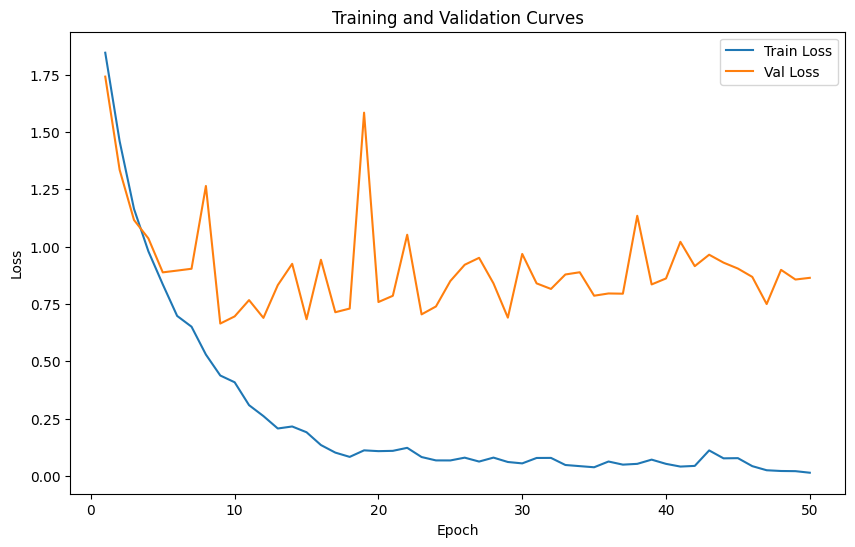

In [ ]:
# Plot the training and validation curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.title('Training and Validation Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Test on Sample Data:**

Predicted Label: 3
Actual Label: 3
Type of sound: dog_bark


Text(0, 0.5, 'Amplitude')

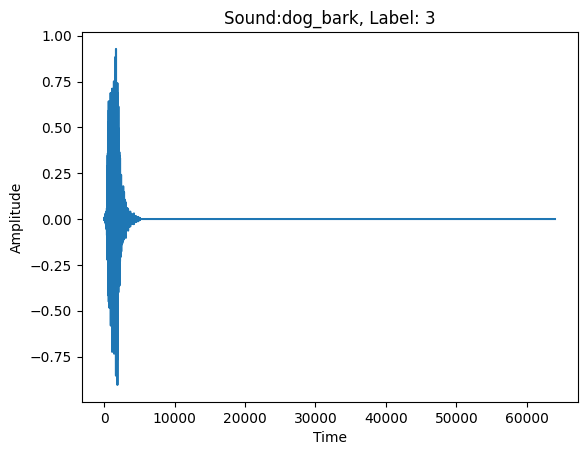

In [ ]:
audio_file = '/content/UrbanSound8K/audio/fold5/100032-3-0-0.wav'

waveform = preprocess_audio_waveform(audio_file)

waveform = waveform.unsqueeze(0).to(device)


model.eval()

with torch.no_grad():
  output = model(waveform)

_, predicted_label = torch.max(output, 1)
predicted_label = predicted_label.item()

print(f"Predicted Label: {predicted_label}")

row = metadata.loc[metadata['slice_file_name']=='100032-3-0-0.wav']

actual_label = row['classID'].values[0]

actual_prediction = row['class'].values[0]

print(f"Actual Label: {actual_label}")
print(f"Type of sound: {actual_prediction}")

waveform = waveform.squeeze().cpu().numpy()

plt.plot(waveform)
plt.title(f"Sound:{actual_prediction}, Label: {predicted_label}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
